
<h3>Build a text classifier to predict actual disaster and non-disastrous tweets in text.</h3>

<h3>This notebook has 4 sections:</h3>

* **Exploring the Data** : In this section, we will explore the data using various visualization plots to gain an insight on our data.
* **Cleaning data**: In this section, we will clean the data and remove the noise in the data.
* **Getting Ready**: In this section, we will transform the data in a suitable format for prediction.
* **Building models**: In this section, we will implement various ML/DL models to classify textual data.

In [2]:
# Importing Libraries

# Used for Data Manipulation and Analysis
import pandas as pd
import numpy as np

# Used for Data Visualization
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('seaborn-bright')

# Used for NLP
import nltk
import re
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

# Used for ML/Deep Learning Algorithms
from tensorflow.keras.layers import Embedding,Dropout
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.layers import LSTM,Bidirectional,GRU,MaxPooling1D,Conv1D
from tensorflow.keras.layers import Dense
from sklearn.metrics import classification_report,accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

# 1: Exploring the Data

<h4>Below cell loads the training and testing data into variables train and test resp. using pandas.</h4>

In [3]:
# Reading data from csv
train = pd.read_csv("../input/nlp-getting-started/train.csv")
test  = pd.read_csv("../input/nlp-getting-started/test.csv")
train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [4]:
test.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [5]:
# cancatenating all cokumns
#train['text']=train['text']+train['location']+train['keyword']

In [6]:
train['text']

0       Our Deeds are the Reason of this #earthquake M...
1                  Forest fire near La Ronge Sask. Canada
2       All residents asked to 'shelter in place' are ...
3       13,000 people receive #wildfires evacuation or...
4       Just got sent this photo from Ruby #Alaska as ...
                              ...                        
7608    Two giant cranes holding a bridge collapse int...
7609    @aria_ahrary @TheTawniest The out of control w...
7610    M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...
7611    Police investigating after an e-bike collided ...
7612    The Latest: More Homes Razed by Northern Calif...
Name: text, Length: 7613, dtype: object

<h4> Let's explore the columns in the dataset </h4>

*  id      : A unique identifier for each tweet.   
*  keyword : A particular keyword from the tweet (may be blank).
*  location: The location the tweet was sent from (may be blank).
*  text    : The text of the tweet.
*  target  : This denotes whether a tweet is about a real disaster (1) or not (0). 

In [7]:
# Displaying rows and columns in dataset

print("There are {} rows and {} columns in training data".format(train.shape[0],train.shape[1]))
print("There are {} rows and {} columns in training data".format(test.shape[0],test.shape[1]))

There are 7613 rows and 5 columns in training data
There are 3263 rows and 4 columns in training data


<h4> Let's explore the Target Variable </h4>

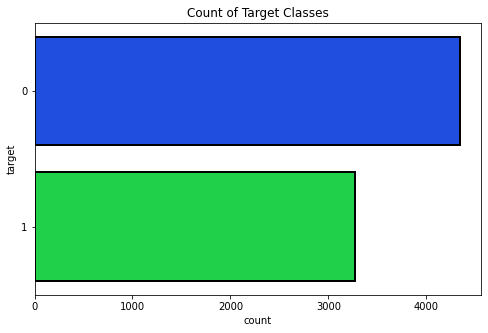

In [8]:
# Visualizing the target classes
plt.figure(figsize=(8,5))
plt.title("Count of Target Classes")
sns.countplot(y=train["target"],linewidth=2,
                   edgecolor='black')

plt.show()

<h4>Inference:-</h4>

*From the Countplot, it can be observed that the total number of samples in Target Class 1 is around 3200 while in Target Class 0, it is about 4500. Also, the classes seems to be in balanced state.*

<h4>Let's start by analysing total number of characters in text.</h4>

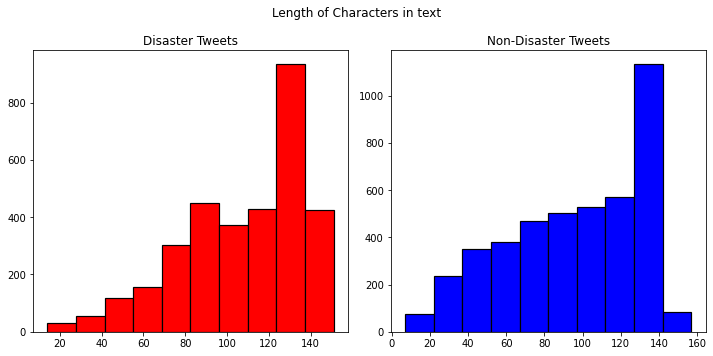

In [9]:
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(10,5))
char_len_dis = train[train['target']==1]['text'].str.len()
ax1.hist(char_len_dis,color='red',edgecolor='black', linewidth=1.2)
ax1.set_title('Disaster Tweets')
char_len_ndis = train[train['target']==0]['text'].str.len()
ax2.hist(char_len_ndis,color='blue',edgecolor='black', linewidth=1.2)
ax2.set_title('Non-Disaster Tweets')
plt.suptitle("Length of Characters in text")
plt.tight_layout()
plt.show()


<h4>Inference:-</h4>

*From the above histograms, it can be observed that the characters count for disaster and non-disaster tweets are in the range of (120,140).*

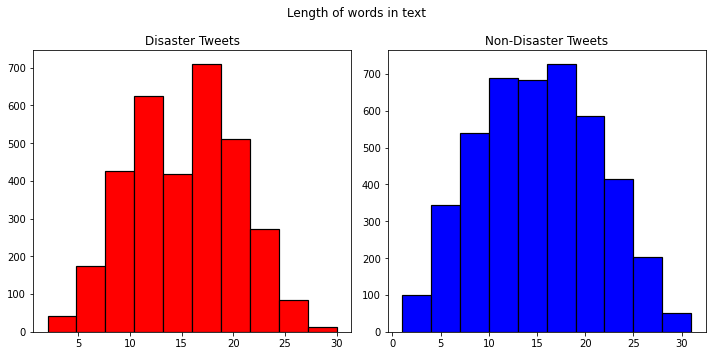

In [10]:
# Analysing number of words in text.

fig,(ax1,ax2) = plt.subplots(1,2,figsize=(10,5))
char_len_dis = train[train['target']==1]['text'].str.split().map(lambda x: len(x))
ax1.hist(char_len_dis,color='red',edgecolor='black', linewidth=1.2)
ax1.set_title('Disaster Tweets')
char_len_ndis = train[train['target']==0]['text'].str.split().map(lambda x: len(x))
ax2.hist(char_len_ndis,color='blue',edgecolor='black', linewidth=1.2)
ax2.set_title('Non-Disaster Tweets')
plt.suptitle("Length of words in text")
plt.tight_layout()
plt.show()

<h4>Inference:-</h4>


*From the above histograms, it can be observed that the words count for disaster and non-disaster tweets are in the range of (15-20).*

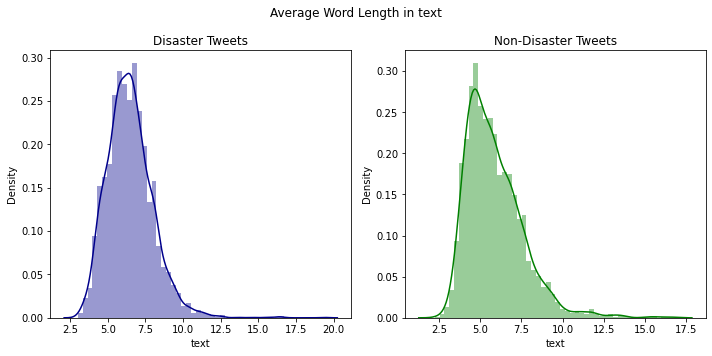

In [11]:
# Analysing average word length in text.

fig,(ax1,ax2) = plt.subplots(1,2,figsize=(10,5))
char_len_dis = train[train['target']==1]['text'].str.split().apply(lambda x: [len(i) for i in x])
sns.distplot(char_len_dis.map(lambda x: np.mean(x)),ax=ax1,color='darkblue')
ax1.set_title('Disaster Tweets')
char_len_ndis = train[train['target']==0]['text'].str.split().apply(lambda x: [len(i) for i in x])
sns.distplot(char_len_ndis.map(lambda x: np.mean(x)),ax=ax2,color='green')
ax2.set_title('Non-Disaster Tweets')
plt.suptitle("Average Word Length in text")
plt.tight_layout()
plt.show()

<h4>Inference:-</h4>


*From the above distributions, it can be observed that the average word count for disaster tweets are found to be in the range(7-7.5) while for non-disaster tweets are in the range of (4.5-5).*



<h4>Below sections perform following analysis:</h4>

* Stop Words Analysis
* Punctuations Analysis
* Analysis of Missing words.

In [12]:
# Creating sample corpus for further analysis.
def create_corpus(target):
    corpus = []
    for x in train[train['target']==target]['text'].str.split():
        for i in x:
            corpus.append(i)
    return corpus
    

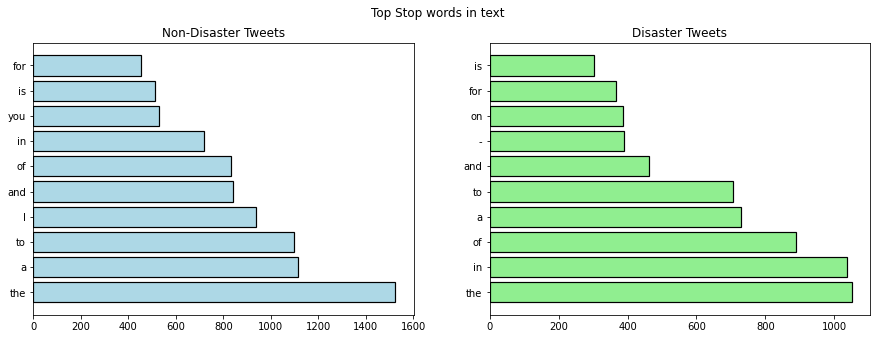

In [13]:
# Analysing top stop words in text.
from collections import defaultdict

def analyze_stopwords(data,func,target):
    values_list = []
    for labels in range(0,len(target)):
        dic = defaultdict(int)
        corpus = func(target[labels])
        for word in corpus:
            dic[word]+=1
        top = sorted(dic.items(),key = lambda x: x[1],reverse=True)[:10]
        x_items,y_values = zip(*top)
        values_list.append(x_items)
        values_list.append(y_values)
    
    fig,(ax1,ax2) = plt.subplots(1,2,figsize=(15,5))
    ax1.barh(values_list[0],values_list[1],color="lightblue",edgecolor='black', linewidth=1.2)
    ax1.set_title("Non-Disaster Tweets")
    
    ax2.barh(values_list[2],values_list[3],color="lightgreen",edgecolor='black', linewidth=1.2)
    ax2.set_title("Disaster Tweets")
            
    plt.suptitle("Top Stop words in text")
    plt.show()

analyze_stopwords(train,create_corpus,[0,1])

<h4>Inference:-</h4>

*The above Bar Charts displays the top 10 stop words in tweets. From the bar chart, it is observed that <strong>the most frequently</strong> occuring stopword in both disaster/non-disaster tweets is <strong>"the"(1000+)</strong> while <strong>the least occuring </strong>for non-disaster is <strong>"for"(400)</strong> and for disaster tweets is <strong>"is"(300)</strong>.*

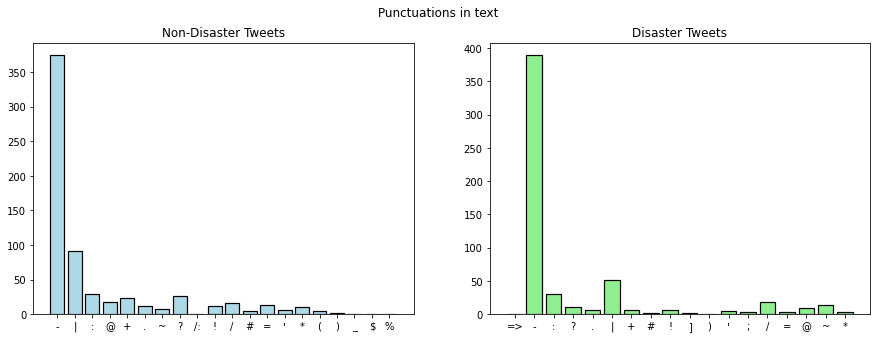

In [14]:
# Anaysing Punctuations
import string

def analyze_punctuation(data,func,target):
    values_list = []
    special = string.punctuation
    for labels in range(0,len(target)):
        dic = defaultdict(int)
        corpus = func(target[labels])
        for i in corpus:
            if i in special:
                dic[i]+=1
        x_items,y_values = zip(*dic.items())
        values_list.append(x_items)
        values_list.append(y_values)
    
    fig,(ax1,ax2) = plt.subplots(1,2,figsize=(15,5))
    ax1.bar(values_list[0],values_list[1],color="lightblue",edgecolor='black', linewidth=1.2)
    ax1.set_title("Non-Disaster Tweets")
    
    ax2.bar(values_list[2],values_list[3],color="lightgreen",edgecolor='black', linewidth=1.2)
    ax2.set_title("Disaster Tweets")
            
    plt.suptitle("Punctuations in text")
    plt.show()

analyze_punctuation(train,create_corpus,[0,1])

<h4>Inference:-</h4>

*The above Bar Charts displays the top 10 punctuations in tweets. From the bar chart, it is observed that <strong>the most </strong> occuring punctuation in both disaster/non-disaster tweets is <strong>"-"(350+)</strong> while <strong>the least occuring </strong>for non-disaster are <strong>"%","/:","$","_"</strong> and for disaster tweets is <strong>"=>", ")"</strong>.*

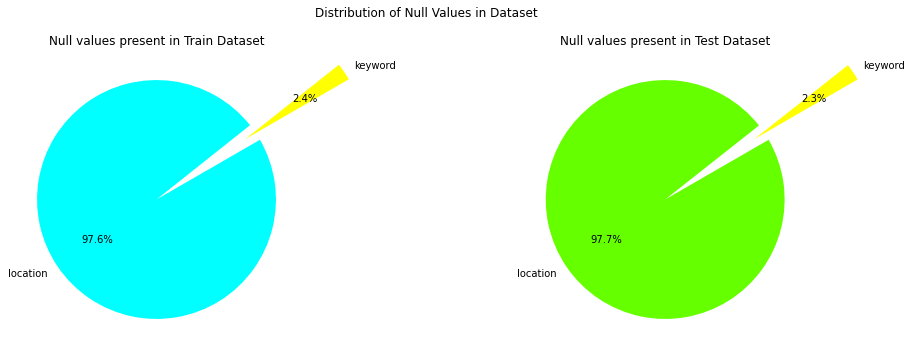

In [15]:
# Checking Null values
missing_train = train.isnull().sum()  
missing_test = test.isnull().sum()  
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(15,5))
missing_train = missing_train[missing_train>0].sort_values()
ax1.pie(missing_train,autopct='%1.1f%%',startangle=30,explode=[0.9,0],labels=["keyword","location"],colors=['yellow','cyan'])
ax1.set_title("Null values present in Train Dataset")

missing_test = missing_test[missing_test>0].sort_values()
ax2.pie(missing_test,autopct='%1.1f%%',startangle=30,explode=[0.9,0],labels=["keyword","location"],colors=['yellow','#66ff00'])
ax2.set_title("Null values present in Test Dataset")
plt.suptitle("Distribution of Null Values in Dataset")
plt.tight_layout()
plt.show()

<h4>Inference:-</h4>

*The above pictorial representation displays the missing values in dataset. From the distribution, it is observed that columns <strong>Keyword and Location</strong> contains  missing values. For training data, the % of missing values  are <strong>97.6 for "location" and 24 for "keywords"</strong> while for testing data, it is  <strong>97.7% for "location" and 23% for keywords</strong>. Also, the column having <strong>maximum missing values is: location</strong> while <strong>Keywords column has the minimum</strong> count of missing values for both sets of data.*

<h4>Let's  analyze the keywords column:-</h4>



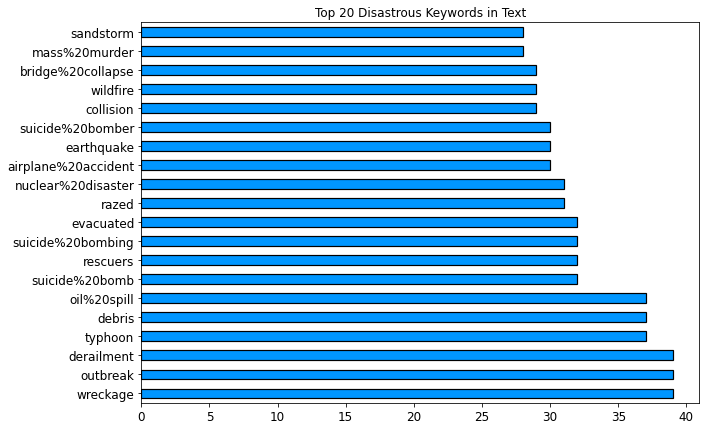

In [16]:
# Analysing Top 20  disastrous KeyWords in text .
plt.figure(figsize=(10,7))
train[train['target']==1]['keyword'].value_counts()[:20].plot(kind='barh', fontsize=12,title='Top 20 Disastrous Keywords in Text', color='#0096FF',edgecolor='black', linewidth=1.2)
plt.show()

<h4>Inference:-</h4>

*The above Bar Chart represents the top 20 disastrous keywords in text. From the bar chart, it is observed that <strong>the most </strong> occuring keywords are <strong>derailment,wreckage,outbreak (35+)</strong> while <strong>the least occuring </strong>are <strong>sandstorm and evacuation (28)</strong>.*

<h4>Let's analyze Locations column:-</h4>

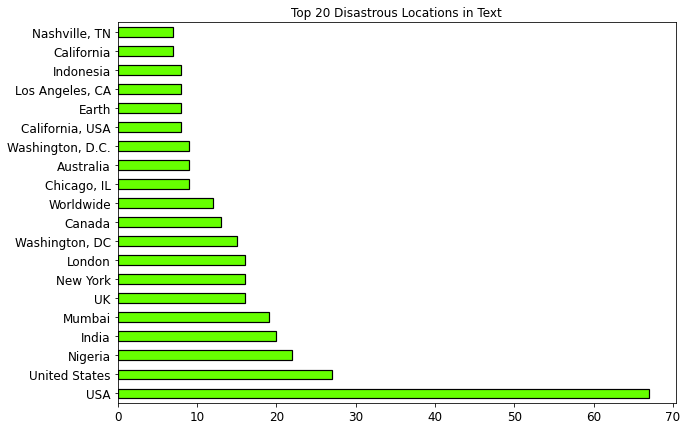

In [17]:
# Analysing Top 20 disastrous Locations in text.
plt.figure(figsize=(10,7))
train[train["target"]==1]["location"].value_counts()[:20].plot(kind='barh',fontsize=12, title='Top 20 Disastrous Locations in Text', color='#66ff00',edgecolor='black', linewidth=1.2)
plt.show()


<h4>Inference:-</h4>

*The above Bar Chart displays the top 20 Locations in tweets. From the chart, it is observed that <strong>the most </strong> occuring/referred location is <strong>USA/United States (68)</strong> while <strong>the least occuring </strong> are <strong>Los Angeles and California (5)</strong>.*

# 2: Cleaning data

<h4> Let's Clean the Data. Following operations are carried out on text column for performing Data Cleaning </h4>

* Removal of URL's.
* Removal of HTMl tags.
* Removal of Emoji's.
* Filtering out miscellaneous text.
* Lowering the text.
* Performing Stemming (in case of bag of words(bow) and tf-idf) and lemmatization for (LSTM).
* Discarding words of length < 2.


Note: The Stemming process is performed for bow and tf-idf because there is no need of meaningful words while lemmatization is performed for LSTM because we do require meaningful words (discussed in subsequent sections).


In [18]:
# Seperating independent and dependent features
X = train.drop(columns=["target"],axis=1)
y = train["target"]

In [19]:
# Perfoming data cleaning

messages_train = X.copy()
messages_test  = test.copy()

ps = PorterStemmer()
wl = WordNetLemmatizer()
def preprocess_data(data):
    '''
    Input: Data to be cleaned.
    Output: Cleaned Data.
    
    '''
    review =re.sub(r'https?://\S+|www\.\S+|http?://\S+',' ',data) #removal of url
    review =re.sub(r'<.*?>',' ',review) #removal of html tags
    review = re.sub("["
                           u"\U0001F600-\U0001F64F"  # removal of emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+",' ',review)
    review = re.sub('[^a-zA-Z]',' ',review) # filtering out miscellaneous text.
    review = review.lower() # Lowering all the words in text
    review = review.split()
    review = [ps.stem(words) for words in review if words not in stopwords.words('english')] #Stemming
    review = [i for i in review if len(i)>2] # Removal of words with length<2
    review = ' '.join(review)
    return review

train["Cleaned_text"] = train["text"].apply(preprocess_data)
test["Cleaned_text"] = test["text"].apply(preprocess_data)

<h4> Let's take a look at Cleaned Data </h4>

In [20]:
train.head()

,id,keyword,location,text,target,Cleaned_text
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,deed reason earthquak may allah forgiv
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,forest fire near rong sask canada
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,resid ask shelter place notifi offic evacu she...
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,peopl receiv wildfir evacu order california
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,got sent photo rubi alaska smoke wildfir pour ...


In [21]:
#train['Cleaned_text']=train['Cleaned_text']+train['location']+train['keyword']

In [22]:
train.tail()

,id,keyword,location,text,target,Cleaned_text
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1,two giant crane hold bridg collaps nearbi home
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1,aria ahrari thetawniest control wild fire cali...
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1,utc volcano hawaii
7611,10872,NaN,NaN,Police investigating after an e-bike collided ...,1,polic investig bike collid car littl portug bi...
7612,10873,NaN,NaN,The Latest: More Homes Razed by Northern Calif...,1,latest home raze northern california wildfir a...


<h4> Let's analyze common words after cleaning of text using Word Cloud</h4>

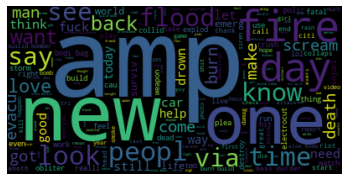

In [23]:
# Analysing common words using WordCloud 

wc = WordCloud(background_color='black')
wc.generate(' '.join(train['Cleaned_text']))
plt.imshow(wc, interpolation="bilinear")
plt.axis('off')
plt.show()

<h4>Inference:-</h4>

*The above displays top common words post the cleaning of text in training data. The most occuring words are: <strong>amp, new, one, people, time etc. </strong>.*

<h4>Let's further analyse top 50 words of disaster/non-disastrous in training data:-</h4>


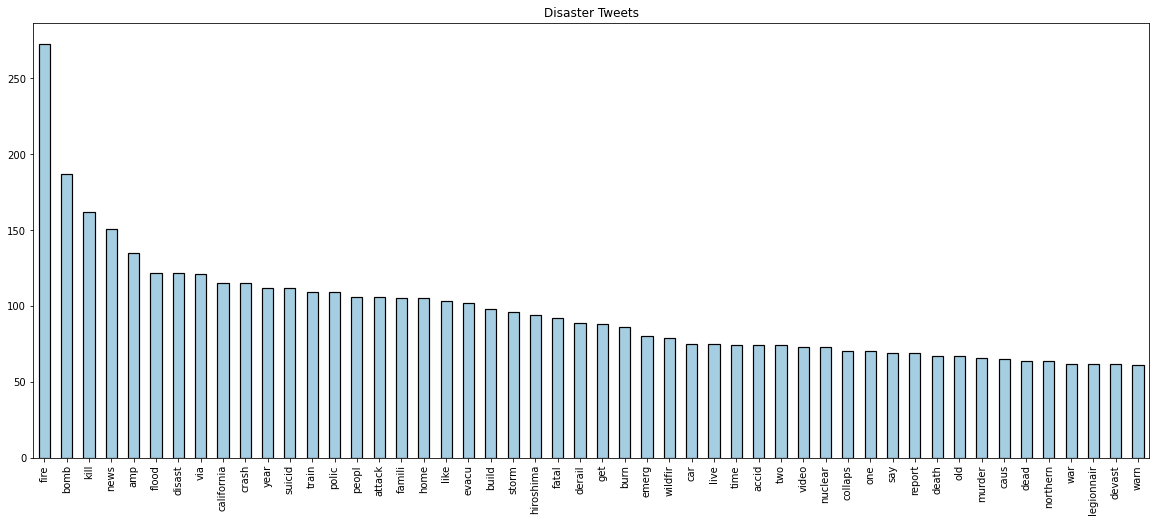

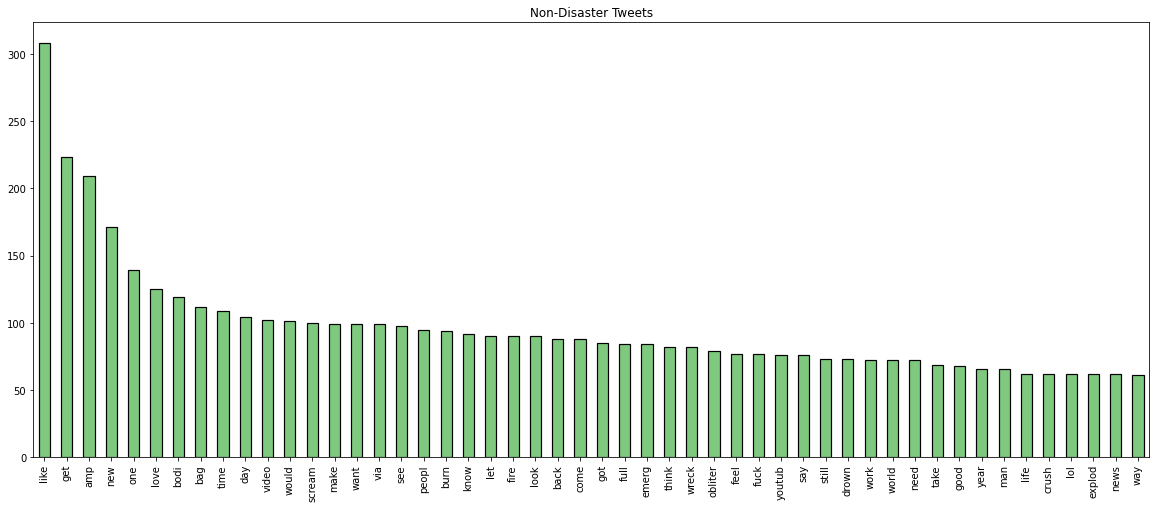

In [24]:
# Analysing top 50 words in training data

disaster_tweet = train[train.target==1]["Cleaned_text"]
non_disaster_tweet = train[train.target==0]["Cleaned_text"]

color = ['Paired','Accent']
splitedData = [disaster_tweet,non_disaster_tweet]
title = ["Disaster Tweets", "Non-Disaster Tweets"]
for item in range(2):
    plt.figure(figsize=(20,8))
    plt.title(title[item],fontsize=12)
    pd.Series(' '.join([i for i in splitedData[item]]).split()).value_counts().head(50).plot(kind='bar',fontsize=10,colormap=color[item],edgecolor='black', linewidth=1.2)
    plt.show()

<h4>Inference:-</h4>

*The above Bar Charts displays the top 50 Words post cleaning in text. From the chart, it is observed that <strong>the most </strong> occuring word for disaster tweets is: <strong> fire (250+)</strong> and for non-disaster is :<strong> like (250+) </strong>while <strong>the least occuring </strong> are <strong> collapse, atomic (80)</strong> for disaster and <strong> feel, really etc. (80) </strong> for non-disastrous.*

<strong> From above chart, it appears that our cleaned text still contains some unnecessary words (such as: like, amp, get, would etc.) that aren't relevant and can confuse our model, resulting in false prediction. Now, we will further remove some confusing words from text based on above charts.</strong>

In [25]:
common_words = ['via','like','build','get','would','one','two','feel','lol','fuck','take','way','may','first','latest'
                'want','make','back','see','know','let','look','come','got','still','say','think','great','pleas','amp']

def text_cleaning(data):
    return ' '.join(i for i in data.split() if i not in common_words)

train["Cleaned_text"] = train["Cleaned_text"].apply(text_cleaning)
test["Cleaned_text"] = test["Cleaned_text"].apply(text_cleaning)

<strong> Let's check one example whether there are any change occured or not</strong>

In [26]:
train.head(1) # Much more cleaner

,id,keyword,location,text,target,Cleaned_text
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,deed reason earthquak allah forgiv


# 3: Getting Ready!! 

<h4> Let's transform the data in numerical format that is suitable for prediction by models. 
     We will use following techniques to transform the data.</h4>

* BOW.
* TF-IDF.
* Word Embbedding using Glove Vectors.

<h4> Let's first start by analysing top N-grams using Bag Of Words.</h4>


In [27]:
# Creating function for analysing top n grams

def top_ngrams(data,n,grams):
    '''
    Input:- Data: Input Data
            n   : Number of top n-words
            grams:Type of N-grams. 1-> Unigram  2-> Bigram  3->Trigram
            
    Output: Word Frequency of top  n words
    
    '''
    if grams == 1:
        count_vec = CountVectorizer(ngram_range=(1,1)).fit(data)
        bow = count_vec.transform(data)
        add_words = bow.sum(axis=0)
        word_freq = [(word, add_words[0, idx]) for word, idx in count_vec.vocabulary_.items()]
        word_freq = sorted(word_freq, key = lambda x: x[1], reverse=True)
    elif grams == 2:
        count_vec = CountVectorizer(ngram_range=(2,2)).fit(data)
        bow = count_vec.transform(data)
        add_words = bow.sum(axis=0)
        word_freq = [(word,add_words[0,idx]) for word,idx in count_vec.vocabulary_.items()]
        word_freq = sorted(word_freq, key = lambda x: x[1], reverse=True)
    elif grams == 3:
        count_vec = CountVectorizer(ngram_range=(3,3)).fit(data)
        bow = count_vec.transform(data)
        add_words = bow.sum(axis=0)
        word_freq = [(word,add_words[0,idx]) for word,idx in count_vec.vocabulary_.items()]
        word_freq = sorted(word_freq, key = lambda x: x[1], reverse=True)

    return word_freq[:n]

<h4> Plotting top 20 N-grams </h4>


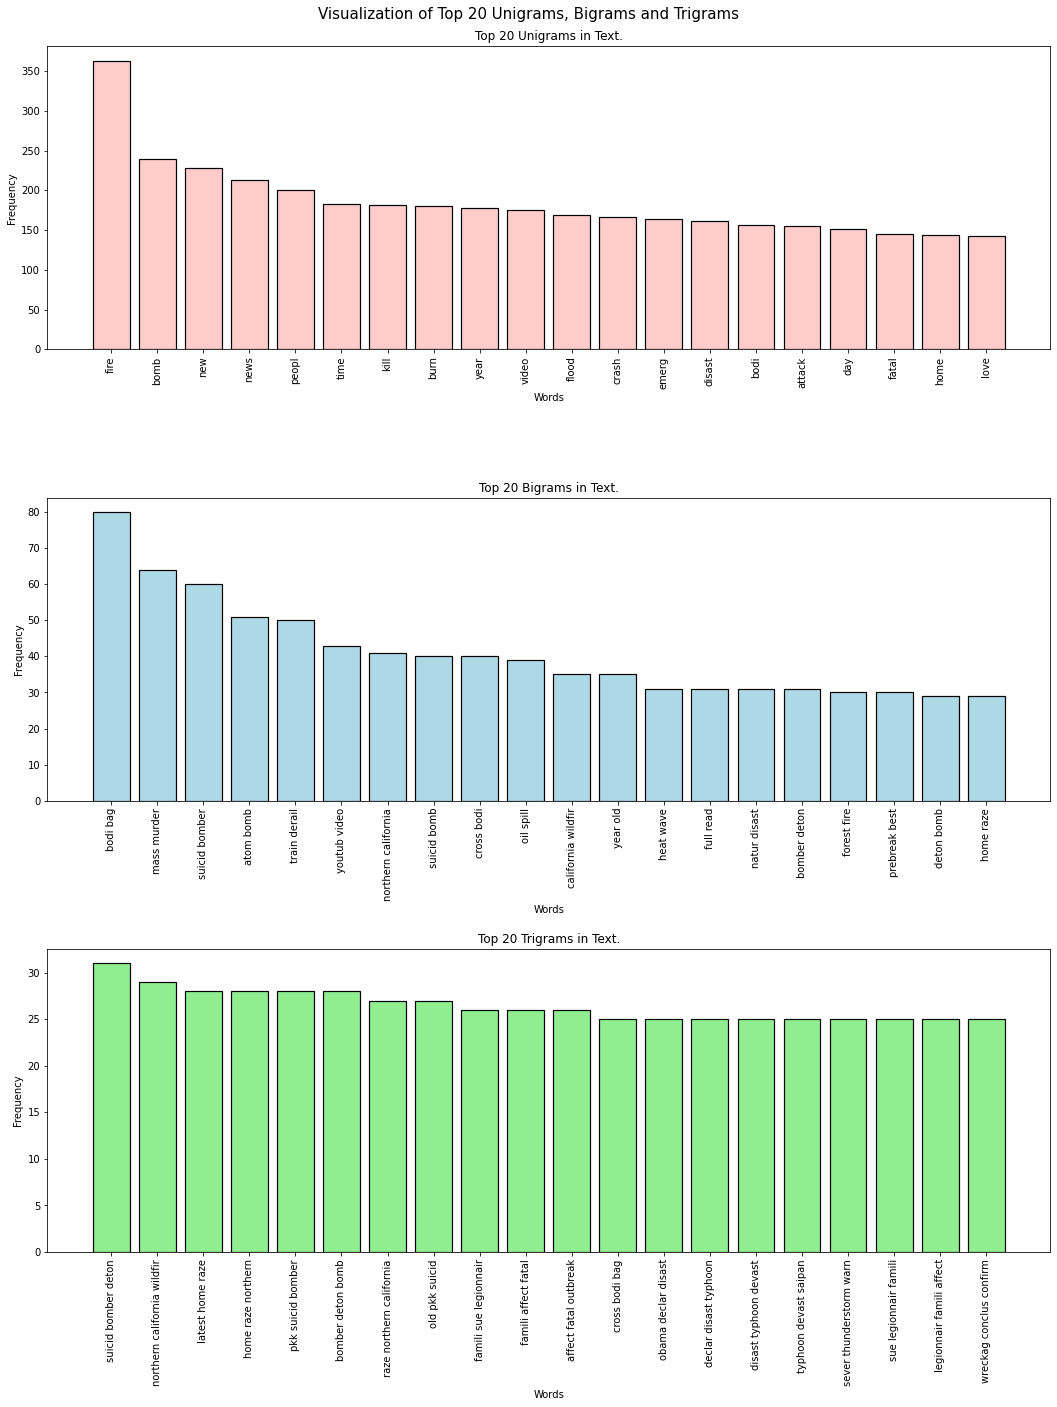

In [28]:
common_words_uni = top_ngrams(train["Cleaned_text"],20,1)
common_words_bi = top_ngrams(train["Cleaned_text"],20,2)
common_words_tri = top_ngrams(train["Cleaned_text"],20,3)
common_words_uni_df = pd.DataFrame(common_words_uni,columns=['word','freq'])
common_words_bi_df = pd.DataFrame(common_words_bi,columns=['word','freq'])
common_words_tri_df = pd.DataFrame(common_words_tri,columns=['word','freq'])
fig,(ax1,ax2,ax3) = plt.subplots(3,1,figsize=(15,20))
ax1.bar(common_words_uni_df["word"],common_words_uni_df["freq"],color="#FFCCCB",edgecolor='black', linewidth=1.2)
ax1.set_title("Top 20 Unigrams in Text.")
ax1.set_xlabel("Words")
ax1.set_ylabel("Frequency")
ax1.set_xticklabels(rotation=90,labels=common_words_uni_df["word"],fontsize=10)    

ax2.bar(common_words_bi_df["word"],common_words_bi_df["freq"],color="lightblue",edgecolor='black', linewidth=1.2)
ax2.set_title("Top 20 Bigrams in Text.")
ax2.set_xlabel("Words")
ax2.set_ylabel("Frequency")
ax2.set_xticklabels(rotation=90,labels=common_words_bi_df["word"],fontsize=10)    

ax3.bar(common_words_tri_df["word"],common_words_tri_df["freq"] ,color="lightgreen",edgecolor='black', linewidth=1.2)
ax3.set_title("Top 20 Trigrams in Text.")
ax3.set_xlabel("Words")
ax3.set_ylabel("Frequency")
ax3.set_xticklabels(rotation=90,labels=common_words_tri_df["word"],fontsize=10) 
plt.suptitle("Visualization of Top 20 Unigrams, Bigrams and Trigrams",fontsize="15")
plt.tight_layout(pad=1.85)
plt.show()


<h4>Inference:-</h4>

*The above Bar Charts displays the top 20 N-Grams. From the chart, it is observed that <strong>the most </strong> occuring unigram in text is: <strong> fire (350+)</strong>, for bigram, it is :<strong> suicide bomber (60) </strong> and for trigram, it is <strong> liked youtube video </strong> while <strong> the least </strong> is <strong> burning (100) </strong> for unigram, it is <strong> home-razed (29)</strong> for bigram and it is <strong>wreckage conclusively confirmed (24)</strong> for trigrams.*

**Perform data encoding using bow and tf-idf.** 

The function accepts cleaned training and testing data, boolean flags for selecting type of encoding as input and outputs cleaned text.

In [29]:
# Creating functions for using BOW,TF-IDF 

def encoding(train_data,test_data,bow,tf_idf):
    '''
    Input : Data to be encoded and choice of encoding.
    Output : Desired Encoding.
    
    '''
    if bow==True: 
        cv = CountVectorizer(ngram_range=(1, 1))
        cv_df_train = cv.fit_transform(train_data).toarray()
        train_df = pd.DataFrame(cv_df_train,columns=cv.get_feature_names())
        cv_df_test = cv.transform(test_data).toarray()
        test_df = pd.DataFrame(cv_df_test,columns=cv.get_feature_names())
        
    elif tf_idf==True:
        
        tfidf = TfidfVectorizer(
            ngram_range=(1, 1), use_idf=1,smooth_idf=1,sublinear_tf=1)    
        tf_df_train = tfidf.fit_transform(train_data).toarray()
        train_df = pd.DataFrame(tf_df_train,columns=tfidf.get_feature_names())
        tf_df_test = tfidf.transform(test_data).toarray()
        test_df = pd.DataFrame(tf_df_test,columns=tfidf.get_feature_names())
        
    return train_df,test_df


x_final,x_test_final = encoding(train["Cleaned_text"],test["Cleaned_text"],bow=True,tf_idf=False)
y_final = np.array(y) # Converting y to array

**In the above code, we have selected n-grams to be (1,1) **

In [30]:
# Checking dimensions of training and testing data
x_final.shape,y_final.shape,x_test_final.shape

((7613, 12687), (7613,), (3263, 12687))

<h4>Using Word Embedding using Glove Vectors for Encoding:-</h4>

In [31]:
#Converting to list
text = train["Cleaned_text"].tolist()
text_test = test["Cleaned_text"].tolist()
text[:3] # Analysing first 3 sentence in train data.

['deed reason earthquak allah forgiv',
 'forest fire near rong sask canada',
 'resid ask shelter place notifi offic evacu shelter place order expect']

**Tokenizer to read all the words in the text.**

In [32]:
from tensorflow.keras.preprocessing.text import Tokenizer
token = Tokenizer()
token.fit_on_texts(text)

In [33]:
# Finding the vocab size
vocab_size = len(token.word_index)+1
print("The vocabulary size is : {}".format(vocab_size))

The vocabulary size is : 12688


In [34]:
# Positions of tokens arranged by tokenizer in vovabulary.

#print(token.index_word)  #==> O/p: 1:'like',2:'fire' etc.

In [35]:
# Encoding tokens in words to numerical formats
encoded_text = token.texts_to_sequences(text)
encoded_text_test = token.texts_to_sequences(text_test)
encoded_text[:2]

[[3492, 430, 182, 1285, 2785], [110, 1, 153, 5026, 5027, 982]]

In [36]:
#Considering 120 words
max_length = 120 # Considering top 120 tokens.
X = pad_sequences(encoded_text,maxlen=max_length,padding='post') # This is done to make the sequence of same length.
X_test = pad_sequences(encoded_text_test,maxlen=max_length,padding='post')
X

array([[3492,  430,  182, ...,    0,    0,    0],
       [ 110,    1,  153, ...,    0,    0,    0],
       [1286,  481, 1570, ...,    0,    0,    0],
       ...,
       [ 580,  378, 1276, ...,    0,    0,    0],
       [  21,  141, 1877, ...,    0,    0,    0],
       [ 142,   19,  361, ...,    0,    0,    0]], dtype=int32)

In [37]:
# Using Glove Vector representations:
# you -0.11076 0.30786 -0.5198 0.035138 0.10368 -0.052505...... -0.35471 0.2331 -0.0067546 -0.18892 0.27837 -0.38501 -0.11408 0.28191 -0.30946 -0.21878 -0.059105 0.47604 0.05661

# The first word is key and rest is their vector reprr.

In [38]:
%%time
#declaring dict to store all the words as keys in the dictionary and their vector representations as values
glove_vectors = dict()

# Now, we will convert the words in glove vectors into key value pairs. We have used glove representation of 200D. 


file = open('../input/glove6b200d/glove.6B.200d.txt',encoding='utf-8')

for line in file:
    values = line.split()  # contains list of keys and their vectors
    word = values[0] # contains words
    vectors = np.asarray(values[1:]) # storing vectors
    glove_vectors[word] = vectors #storing the vector representation of the respective word in the dictionary
file.close()

CPU times: user 32.1 s, sys: 5.02 s, total: 37.1 s
Wall time: 39.5 s


In [39]:
# Checking length of glove vectors
print("The maximum size of global vectors is : {}".format(len(glove_vectors)))

The maximum size of global vectors is : 400000


In [40]:
# Checking dimensions of Glove Vectors.
glove_vectors.get('you').shape

(200,)

In [41]:
# Now we are creating a matrix for the tokens which we are having in our dataset and then storing their vector representation values in the matrix if it matches with glove_vectors words else print the misspelled words or words which are not present.

word_vector_matrix = np.zeros((vocab_size,200))  # size of the word matrix
for word,index in token.word_index.items():
    vector = glove_vectors.get(word)
    if vector is not None:
        word_vector_matrix[index] = vector
    #else:
        #print(word)

In [42]:
print("The Size of Word Matrix is :{}".format(word_vector_matrix.shape))

The Size of Word Matrix is :(12688, 200)


In [43]:
#train['text']=train['text'] +''+train['location']+''+train['keyword']

# 4: Building models




In [44]:
# Dividing the data into training, validation and testing
from sklearn.model_selection import train_test_split
# for bow and tf-idf
#x_train, x_test, y_train, y_test = train_test_split(x_final, y_final, test_size=0.1, random_state=42, stratify = y_final)
#X_train, x_valid, Y_train, y_valid = train_test_split(x_train, y_train, test_size=0.1, random_state=42, stratify = y_train)
#x_test_final = x_test_final

#  for Word Embeddings
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42, stratify = y)
X_train, x_valid, Y_train, y_valid = train_test_split(x_train, y_train, test_size=0.1, random_state=42, stratify = y_train)
#x_test_final = x_test_final

**1. Logistic Regression**

In [45]:
model_1 = LogisticRegression(C=1.0)
model_1.fit(X_train,Y_train)
pred_1 = model_1.predict(x_test)
cr1    = classification_report(y_test,pred_1)
print(cr1)

              precision    recall  f1-score   support

           0       0.57      0.92      0.71       435
           1       0.45      0.08      0.14       327

    accuracy                           0.56       762
   macro avg       0.51      0.50      0.42       762
weighted avg       0.52      0.56      0.46       762



**3. XGBOOST (Untuned)**

In [46]:
model_5 = XGBClassifier()
model_5.fit(X_train,Y_train)
pred_5 = model_5.predict(x_test)
cr5    = classification_report(y_test,pred_5)
print(cr5)

[09:37:52] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
              precision    recall  f1-score   support

           0       0.70      0.76      0.73       435
           1       0.65      0.57      0.61       327

    accuracy                           0.68       762
   macro avg       0.68      0.67      0.67       762
weighted avg       0.68      0.68      0.68       762



In [47]:
# Finding the max. length of sentences 

'''
curr_length = 0
prev_length = 0

def calc_len(data,curr_length,prev_length):
    
    
    Input: Data for which length is to be calculated.
    Output: Calculated length.
    
    
    result = 0
    for i in range(0,len(data)):
        curr_length = len(data[i])
        if curr_length > prev_length:
            prev_length = curr_length

        else:
            i+=1

        curr_length = 0
        
    result = prev_length
    return result

train_length = calc_len(one_hot_train,curr_length,prev_length)
test_length  = calc_len(one_hot_test,curr_length,prev_length)
print("The length of training data: {} and testing data {}.".format(train_length,test_length))
'''

'\ncurr_length = 0\nprev_length = 0\n\ndef calc_len(data,curr_length,prev_length):\n    \n    \n    Input: Data for which length is to be calculated.\n    Output: Calculated length.\n    \n    \n    result = 0\n    for i in range(0,len(data)):\n        curr_length = len(data[i])\n        if curr_length > prev_length:\n            prev_length = curr_length\n\n        else:\n            i+=1\n\n        curr_length = 0\n        \n    result = prev_length\n    return result\n\ntrain_length = calc_len(one_hot_train,curr_length,prev_length)\ntest_length  = calc_len(one_hot_test,curr_length,prev_length)\nprint("The length of training data: {} and testing data {}.".format(train_length,test_length))\n'

In [48]:
# Correcting spellings
#!pip install pyspellchecker
'''
from spellchecker import SpellChecker
from tqdm import tqdm
spell = SpellChecker()
def correct_spell(text):
    corrected_text = []
    mispelled_words = spell.unknown(text.split())
    for word in tqdm(text.split()):
        if word in mispelled_words:
            corrected_text.append(spell.correction(text))
        else:
            corrected_text.append(word)
    return " ".join(corrected_text)

train["Cleaned_text"] = train["Cleaned_text"].apply(lambda x: correct_spell(x))
'''

'\nfrom spellchecker import SpellChecker\nfrom tqdm import tqdm\nspell = SpellChecker()\ndef correct_spell(text):\n    corrected_text = []\n    mispelled_words = spell.unknown(text.split())\n    for word in tqdm(text.split()):\n        if word in mispelled_words:\n            corrected_text.append(spell.correction(text))\n        else:\n            corrected_text.append(word)\n    return " ".join(corrected_text)\n\ntrain["Cleaned_text"] = train["Cleaned_text"].apply(lambda x: correct_spell(x))\n'

In [49]:
#train['text']=train['text'] +''+train['location']+''+train['keyword']

**3. Long Short Tem Memory (LSTM)**

In [50]:
from keras.optimizers import Adam,SGD
from tensorflow.keras import regularizers

embedding_feature_vector = 200 # Since we used glove vector embedding of dim 200.
model = Sequential()
model.add(Embedding(vocab_size,embedding_feature_vector,input_length=max_length,weights = [word_vector_matrix], trainable = False))
model.add(Dropout(0.35))
model.add(LSTM(200))
model.add(Dropout(0.35))
model.add(Dense(32,activation='relu'))
model.add(Dense(1,activation='sigmoid'))
model.compile(loss='binary_crossentropy',optimizer=Adam(lr=1e-4),metrics=['accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 120, 200)          2537600   
_________________________________________________________________
dropout (Dropout)            (None, 120, 200)          0         
_________________________________________________________________
lstm (LSTM)                  (None, 200)               320800    
_________________________________________________________________
dropout_1 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense (Dense)                (None, 32)                6432      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 2,864,865
Trainable params: 327,265
Non-trainable params: 2,537,600
________________________________________

In [51]:
from tensorflow.keras.callbacks import *
n_epoch = 30

early_stop = EarlyStopping(monitor='val_loss', patience=5, verbose=1, 
                           mode='min', restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, 
                              verbose=1, mode='min')

In [52]:
# Training the model
history = model.fit(X_train,Y_train,validation_data=(x_valid,y_valid),callbacks=[reduce_lr,early_stop],epochs=n_epoch,batch_size= 32)

Epoch 1/30
193/193 [==============================] - 55s 268ms/step - loss: 0.6751 - accuracy: 0.5934 - val_loss: 0.5508 - val_accuracy: 0.7464
Epoch 2/30
193/193 [==============================] - 51s 265ms/step - loss: 0.5434 - accuracy: 0.7537 - val_loss: 0.5029 - val_accuracy: 0.7697
Epoch 3/30
193/193 [==============================] - 54s 278ms/step - loss: 0.5254 - accuracy: 0.7627 - val_loss: 0.4868 - val_accuracy: 0.7711
Epoch 4/30
193/193 [==============================] - 51s 263ms/step - loss: 0.5252 - accuracy: 0.7628 - val_loss: 0.5095 - val_accuracy: 0.7697
Epoch 5/30
193/193 [==============================] - 51s 265ms/step - loss: 0.5006 - accuracy: 0.7689 - val_loss: 0.5004 - val_accuracy: 0.7857
Epoch 6/30
193/193 [==============================] - 50s 260ms/step - loss: 0.5004 - accuracy: 0.7820 - val_loss: 0.4727 - val_accuracy: 0.7872
Epoch 7/30
193/193 [==============================] - 51s 266ms/step - loss: 0.4877 - accuracy: 0.7854 - val_loss: 0.4780 - val_ac

In [53]:
predictions = model.predict_classes(x_test)
cr = classification_report(y_test,predictions)
print(cr)

              precision    recall  f1-score   support

           0       0.80      0.86      0.83       435
           1       0.80      0.72      0.76       327

    accuracy                           0.80       762
   macro avg       0.80      0.79      0.79       762
weighted avg       0.80      0.80      0.80       762



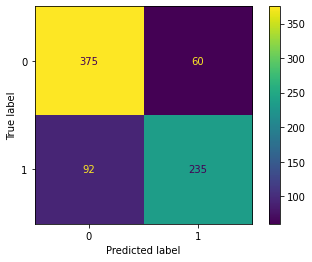

In [54]:
from sklearn import metrics
confusion_matrix = metrics.confusion_matrix(y_test,predictions)
confusion_matrix
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [0, 1])

cm_display.plot()
plt.show()

In [55]:
weights_82 = model.save_weights('weights_82_81(82).h5')
model_82 = model.to_json()

In [56]:
# Verifying the results.
from tensorflow.keras.models import model_from_json
model = model_from_json(model_82)
model.load_weights('./weights_82_81(82).h5')
model.compile(loss='binary_crossentropy',optimizer=Adam(lr=1e-4),metrics=['accuracy'])
print(model.summary())
model.evaluate(x_test, y_test, batch_size=64, verbose=2)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 120, 200)          2537600   
_________________________________________________________________
dropout (Dropout)            (None, 120, 200)          0         
_________________________________________________________________
lstm (LSTM)                  (None, 200)               320800    
_________________________________________________________________
dropout_1 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense (Dense)                (None, 32)                6432      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 2,864,865
Trainable params: 327,265
Non-trainable params: 2,537,600
________________________________________

[0.4525710642337799, 0.8005249500274658]

<h4> Conclusion </h4>

From the above table, it appears that <strong>LSTM model </strong>performs the best by achieving an overall accuracy of about <strong>80% </strong> Since, the LSTM Model shows robust performance, therefore it is selected as the final prediction model. </h4>

In [57]:
# Making Predictions on test data
predictions_test = pd.DataFrame(model.predict_classes(X_test))
test_id = pd.DataFrame(test["id"])
submission = pd.concat([test_id,predictions_test],axis=1)
submission.columns = ["id","target"]
submission.to_csv("result.csv",index=False)

In [59]:
submission.head()

,id,target
0,0,1
1,2,0
2,3,1
3,9,0
4,11,1
